# Best Predictive Model With XGBoost and Bayes Optimization in R

This notebook contains codes showing how to build predictive classification model integrating XGBoost BayesOptimization in R Programming. XGBoost, eXtreme Gradient Boosting, is a powerful technique for building predictive models from complex data. It is popular for its fast and accurate results.

Bayes Optimization is a strategy for selecting the best parameters for a model. Instead of utilising exhausive combination through grid search, this strategy uses Bayesian statistics to predict which combunation of hyperparameters might lead to better performance. This method reduce time and resources used in building model.

Together, using XGBoost with Bayes Optimization in R allows for efficient and effective modeling, helping to pinpoint the optimal settings for the best predictive performance.

It is noted that this notebook provides a demonstration on how to integrate Bayes Optimization into model selection. It does not cover extensive feature engineering and feature selection, which are crucial for building robust models.

#### Documentation on XGBoost can be found here:

- A Guide on XGBoost hyperparameters tuning: https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning

- Understand your dataset with XGBoost: https://cran.r-project.org/web/packages/xgboost/vignettes/discoverYourData.html


#### Documentations on Bayes Optimization can be found here:

 - Kaggle Grandmaster Guide: https://forecastegy.com/posts/xgboost-hyperparameter-tuning-with-optuna/

 - R Documents: https://cran.r-project.org/web/packages/rBayesianOptimization/rBayesianOptimization.pdf

 - Math behind Bayes Optimization: https://sassafras13.github.io/BayesianOptimization/

In [1]:
# Load libraries
library(tidyverse)
library(xgboost)
library(data.table)
library(rBayesianOptimization)
library(yardstick)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice



Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose



Attaching package: ‘yardstick’


The follow

## Multi-classification

In this demonstration, we aim to predict multiple classes related to mental health based on a dataset derived from a survey on behavior associated with mental health issues. The model is evaluated using the macro-F1 score, which is a suitable metric for multi-class classification problems, especially to assess balance across class predictions. We have defined a custom function to calculate the macro-F1 score, which is integrated into our objective function for model optimization. 

### Objective function

The objective function specifies the hyperparameters of XGBoost that we want to tune. It includes cross-validation and utilizes our custom macro-F1 evaluation function. The goal is to optimize these settings to achieve the highest possible F1 score, indicating the best overall class prediction accuracy close to 1.


### Train/Test Split

We have partitioned the dataset into an 80% training set and a 20% testing set. Despite the dataset containing only 594 observations, we incorporate k-fold cross-validation in our objective function for demonstration purposes. It is important to note that k-fold cross-validation should be used with caution in small datasets due to potential overfitting and variability in the training segments.

We perform Bayes Optimization on training set and extract best parameters. After identifying these parameters, we apply them to fit the model to our data. Additionally, we utilise a watchlist during the training process, which includes both the training set and the test set. This allows us to monitor the model’s performance in real-time, ensuring that it performs well both on seen (training) and unseen (test) data.

To visually assess the model's performance over the training iterations, we plot a learning curve. This plot displays changes in the macro-F1 score across both the training and test datasets over each iteration of model training. 

In [2]:
# Load the dataset
class_data <- read.csv("/kaggle/input/classification-xgb-bayesopt/classification_xgb_bayesopt.csv")

# Convert character features into factor
new_non_num_cols <- sapply(class_data, is.character)
for (col in names(class_data)[new_non_num_cols]) {
    class_data[[col]] <- factor(class_data[[col]])
}

In [3]:
# Convert target into numerical and ensure it starts with zero
class_data$target <- as.integer(as.factor(class_data$target)) - 1

head(class_data$target)

[1] 2 4 0 1 1 4

In [4]:
set.seed(12)

# Splitting the data 80:20 for train:test
indices <- sample(1:nrow(class_data), 0.8 * nrow(class_data))
train <- class_data[indices, ]
test <- class_data[-indices, ]

# Extract target variable
train_target <- train$target
test_target <- test$target

# Create data matrix for XGBoost
train_features <- model.matrix(target ~ .- 1, data = train)
test_features <- model.matrix(target ~ . - 1, data = test)

# Convert the data to xgb.DMatrix format
train_dMatrix <- xgb.DMatrix(data = train_features, label = train_target)
test_dMatrix <- xgb.DMatrix(data = test_features, label = test_target)


In [5]:
print("Train Data Matrix: ")
train_dMatrix

print("\nTest Data Matrix: ")
test_dMatrix

[1] "Train Data Matrix: "


xgb.DMatrix  dim: 475 x 69  info: label  colnames: yes

[1] "\nTest Data Matrix: "


xgb.DMatrix  dim: 119 x 69  info: label  colnames: yes

In [6]:
# Define function to calcualte macro F1

macroF1_eval <- function(predictions, dataMatrix) {
    labels <- getinfo(dataMatrix, "label")
    num_class <- 5
    preds_matrix <- matrix(predictions, ncol = num_class, byrow = TRUE)
    pred_labels <- max.col(preds_matrix) - 1
    
    # Compute macro F1
    f1_scores <- sapply(0:(num_class - 1), function(class) {
        true_pos <- sum(labels == class & pred_labels == class)
        false_pos <- sum(labels != class & pred_labels == class)
        false_neg <- sum(labels == class & pred_labels != class)
        
        precision <- ifelse(true_pos + false_pos == 0, 0, true_pos / (true_pos + false_pos))
        recall <- ifelse(true_pos + false_neg == 0, 0, true_pos / (true_pos + false_neg))
        return(ifelse(precision + recall == 0, 0, 2 * (precision * recall) / (precision + recall)))
  })
    
    # Average the f1 scores
    macro_f1 <- mean(f1_scores)
    
    # Return name of matric and its value
    return(list(metric = "macro_f1", value = macro_f1))
}

## XGBoost and its hyperparameters

The list below includes hyperparameters used in tuning the XGBoost model in this demo. For more indepth information, please refer to https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning

1. **eta (Learning Rate)** controls the step size at each iteration while moving toward a minimum of a loss function.

2. **max_depth** determines the maximum depth of a tree.

3. **gamma (Minimum Loss Reduction)** specifies the minimum loss reduction.

4. **colsample_bytree** specifies fraction of features (columns) used per tree.

5. **min_child_weight** defines the minimum sum of instance weight needed in a child.

6. **subsample** Fraction of the training instances to be used for each tree building.

7. **lambda (L2 Regularization Term)** provides regularization on weights.

8. **alpha (L1 Regularization Term)** can be used for feature selection by making coefficients zero for the least important features. A range of 0 to 10 allows some regularization without overly constraining the model.

In [7]:
# Define objective function

bayesOpt_xgb <- function(eta, max_depth, gamma, colsample_bytree, min_child_weight, 
                     subsample, lambda, alpha, early_stopping_rounds) {
    parameters <- list(
        objective = "multi:softmax",
        num_class = 5,
        eta = eta,
        max_depth = as.integer(max_depth),
        gamma = gamma,
        colsample_bytree = colsample_bytree,
        min_child_weight = as.integer(min_child_weight),
        subsample = subsample,
        lambda = lambda,
        alpha = alpha,
        nthread = 6
    )

  # Set Cross-validation
  cv_results <- xgb.cv(
    params = parameters,
    data = train_dMatrix,
    nrounds = 100, 
    nfold = 5,
    stratified = TRUE,
    early_stopping_rounds = 20,
    verbose = FALSE,
    feval = macroF1_eval,
    maximize = TRUE
  )

  # Extract the best F1 score 
  best_f1_score <- max(cv_results$evaluation_log$test_macro_f1_mean, na.rm = TRUE)

  # Return the best F1 score 
  return(list(Score = best_f1_score))
}

In [8]:
# Bayes Optimisation
# This is a basic setup for demo. Please make change to parameters as you wish 
set.seed(49)

bayesOpt_result <- BayesianOptimization(
  FUN = bayesOpt_xgb,
  bounds = list(
      eta = c(0.1, 0.3), 
      max_depth = c(3, 5),
      gamma = c(0, 1),
      colsample_bytree = c(0.4, 0.8),
      min_child_weight = c(1, 4),  
      subsample = c(0.6, 0.8),
      lambda = c(0, 5),
      alpha = c(0, 5)
  ),
    
  init_points = 5,
  n_iter = 10,
  acq = "ucb",
  kappa = 2.576
)

elapsed = 5.755	Round = 1	eta = 0.1731398	max_depth = 3.593208	gamma = 0.2569477	colsample_bytree = 0.406759	min_child_weight = 1.874893	subsample = 0.7766479	lambda = 3.371369	alpha = 2.712157	Value = 0.4052838 
elapsed = 4.521	Round = 2	eta = 0.1975708	max_depth = 3.540018	gamma = 0.4394838	colsample_bytree = 0.6618116	min_child_weight = 3.532568	subsample = 0.77541	lambda = 3.556285	alpha = 4.484823	Value = 0.3780134 
elapsed = 4.259	Round = 3	eta = 0.153962	max_depth = 3.200008	gamma = 0.1262925	colsample_bytree = 0.4823895	min_child_weight = 2.443499	subsample = 0.6340104	lambda = 0.495752	alpha = 2.873392	Value = 0.4302846 
elapsed = 6.063	Round = 4	eta = 0.2213645	max_depth = 4.060866	gamma = 0.6659399	colsample_bytree = 0.5894632	min_child_weight = 3.386965	subsample = 0.7891022	lambda = 2.761201	alpha = 3.024443	Value = 0.3952925 
elapsed = 4.368	Round = 5	eta = 0.1091618	max_depth = 4.64986	gamma = 0.9858441	colsample_bytree = 0.5837352	min_child_weight = 1.387103	subsample =

In [9]:
# Inspect the result from BayesOpt
# Best parameters is denoted as $Best_par, while the best Macro F1 is denoted as $Best_Value

bayesOpt_result


Round,eta,max_depth,gamma,colsample_bytree,min_child_weight,subsample,lambda,alpha,Value
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.1731398,3.593208,0.2569477,0.4067590,1.874893,0.7766479,3.371369e+00,2.712157e+00,0.4052838
2,0.1975708,3.540018,0.4394838,0.6618116,3.532568,0.7754100,3.556285e+00,4.484823e+00,0.3780134
3,0.1539620,3.200008,0.1262925,0.4823895,2.443499,0.6340104,4.957520e-01,2.873392e+00,0.4302846
4,0.2213645,4.060866,0.6659399,0.5894632,3.386965,0.7891022,2.761201e+00,3.024443e+00,0.3952925
5,0.1091618,4.649860,0.9858441,0.5837352,1.387103,0.6305044,3.549539e-01,1.047431e+00,0.4031353
6,0.1345035,4.393152,0.9430265,0.8000000,1.127460,0.7982368,2.220446e-16,2.220446e-16,0.3935874
7,0.1050856,4.195060,1.0000000,0.7368690,4.000000,0.7732216,2.220446e-16,3.566009e+00,0.3559639
8,0.1272402,3.994796,0.9782456,0.7604301,2.279932,0.6228711,4.259936e+00,3.865945e+00,0.3616513
9,0.3000000,4.197866,0.4361407,0.5089703,3.306670,0.7804701,1.270447e+00,2.220446e-16,0.3868854


In [10]:
# Extracting the best parameters
best_params <- bayesOpt_result$Best_Par

# Printing the best parameters
best_params

eta        max_depth            gamma colsample_bytree 
       0.1539620        3.2000082        0.1262925        0.4823895 
min_child_weight        subsample           lambda            alpha 
       2.4434991        0.6340104        0.4957520        2.8733925

In [11]:
# Use best parameters on params, which will be used to build the model

# Get the list of best parameters
params <- list(
    objective = "multi:softmax",
    num_class = 5,
    eta = best_params["eta"],
    max_depth = as.integer(best_params["max_depth"]),
    gamma = best_params["gamma"],
    colsample_bytree = best_params["colsample_bytree"],
    min_child_weight = as.integer(best_params["min_child_weight"]),
    subsample = best_params["subsample"],lambda = best_params["lambda"],
    alpha = best_params["alpha"]
)

# Check params
params


$objective
[1] "multi:softmax"

$num_class
[1] 5

$eta
     eta 
0.153962 

$max_depth
[1] 3

$gamma
    gamma 
0.1262925 

$colsample_bytree
colsample_bytree 
       0.4823895 

$min_child_weight
[1] 2

$subsample
subsample 
0.6340104 

$lambda
  lambda 
0.495752 

$alpha
   alpha 
2.873392

In [12]:
# Build the model and silmultaneously check model performance

# Set watchlist for checking model performance
watchlist <- list(train = train_dMatrix, test = test_dMatrix)

xgb_model <- xgb.train(
    params = params,
    data = train_dMatrix,
    nrounds = 400,
    watchlist = watchlist,
    feval = macroF1_eval,
    early_stopping_rounds = 10,
    maximize = TRUE
)


[1]	train-macro_f1:0.361329	test-macro_f1:0.201306 
Multiple eval metrics are present. Will use test_macro_f1 for early stopping.
Will train until test_macro_f1 hasn't improved in 10 rounds.

[2]	train-macro_f1:0.390721	test-macro_f1:0.233560 
[3]	train-macro_f1:0.423387	test-macro_f1:0.219483 
[4]	train-macro_f1:0.424660	test-macro_f1:0.229036 
[5]	train-macro_f1:0.477302	test-macro_f1:0.243770 
[6]	train-macro_f1:0.465649	test-macro_f1:0.339126 
[7]	train-macro_f1:0.471143	test-macro_f1:0.324757 
[8]	train-macro_f1:0.498037	test-macro_f1:0.300549 
[9]	train-macro_f1:0.501594	test-macro_f1:0.307732 
[10]	train-macro_f1:0.526500	test-macro_f1:0.303866 
[11]	train-macro_f1:0.530417	test-macro_f1:0.314976 
[12]	train-macro_f1:0.560757	test-macro_f1:0.322075 
[13]	train-macro_f1:0.558906	test-macro_f1:0.315274 
[14]	train-macro_f1:0.560364	test-macro_f1:0.312607 
[15]	train-macro_f1:0.568160	test-macro_f1:0.326697 
[16]	train-macro_f1:0.580006	test-macro_f1:0.319557 
Stopping. Best iterat

In [13]:
# Look at the evaluation log
eval_log <- xgb_model$evaluation_log
eval_log


iter,train_macro_f1,test_macro_f1
<dbl>,<dbl>,<dbl>
1,0.3613291,0.2013063
2,0.3907211,0.2335603
3,0.4233871,0.2194826
4,0.4246604,0.2290365
5,0.4773018,0.2437701
6,0.4656487,0.3391257
7,0.4711427,0.3247573
8,0.4980373,0.3005492
9,0.5015939,0.3077319


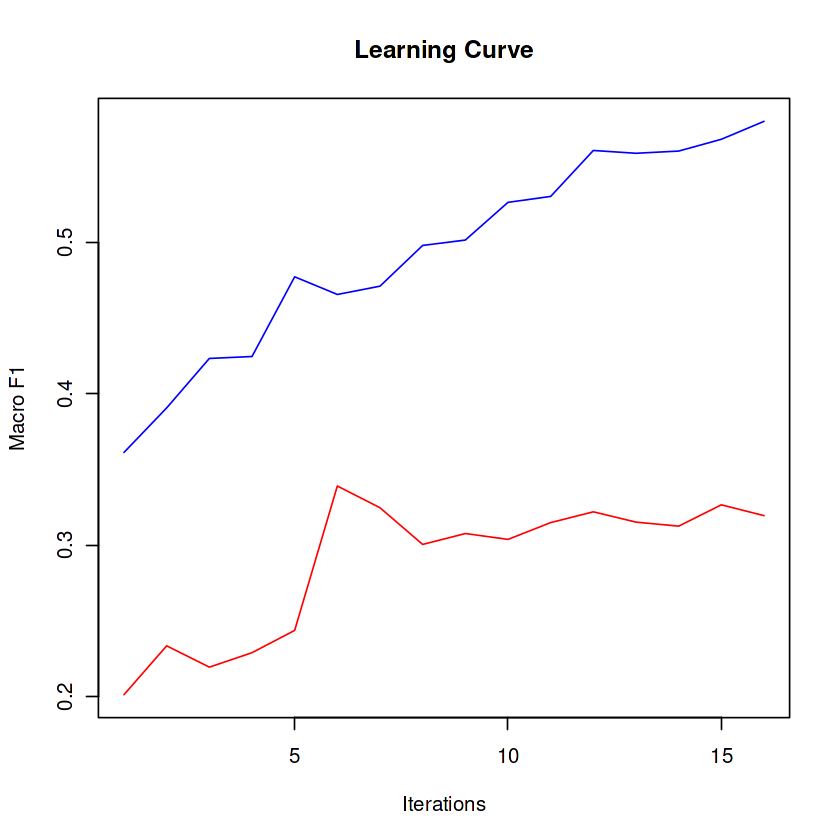

In [14]:
# Plot learning curve
plot(eval_log$iter, eval_log$train_macro_f1, type="l", col="blue", 
     xlab="Iterations", ylab="Macro F1", 
     ylim=c(min(eval_log$train_macro_f1, eval_log$test_macro_f1), 
            max(eval_log$train_macro_f1, eval_log$test_macro_f1)),
     main="Learning Curve")
lines(eval_log$iter, eval_log$test_macro_f1, col="red")

In [15]:
# Get the best number of rounds
best_nrounds <- xgb_model$best_iteration
best_nrounds

[1] 6